In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import utils
from torchvision import datasets
from torchvision import transforms
from PIL import Image
import urllib.request as request
from matplotlib import pyplot as plt
from skimage import io
#torch.set_printoptions(edgeitems=2) #default 3
#torch.manual_seed(123)

### Create Model

In [8]:
data_path = 'data/'
full_data_set = datasets.CIFAR10(data_path, train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))]))
full_validation_set = datasets.CIFAR10(data_path, train=False, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))]))

Files already downloaded and verified
Files already downloaded and verified


In [9]:
print(type(full_data_set))
print(type(full_validation_set))

<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'torchvision.datasets.cifar.CIFAR10'>


In [10]:
size = 16
dataloader = torch.utils.data.DataLoader(full_data_set,batch_size=size,shuffle=True,num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


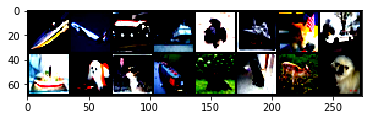

In [11]:
data_iterator = iter(dataloader)
imgs,labels = data_iterator.next()
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
plt.imshow(utils.make_grid(imgs).permute(1, 2, 0))

In [12]:
class_names = ['dog','cat']
label_map = {1:0,3:1}
data_set = [(img,label_map[label]) for img,label in full_data_set if label in [1,3]]
validation_set = [(img, label_map[label]) for img,label in full_validation_set if label in [1,3]]

In [13]:
img,label = data_set[16]
img.shape

torch.Size([3, 32, 32])

In [14]:
model = nn.Sequential(nn.Linear(3*32*32,512),nn.Tanh(),nn.Linear(512,2))

From https://www.geeksforgeeks.org/python-tensorflow-nn-tanh/:

The module tensorflow.nn provides support for many basic neural network operations.

One of the many activation functions is the hyperbolic tangent function (also known as tanh) which is defined as tanh(x) = (e^z - e^{-z}) / (e^z + e^{-z}).

More on: https://www.programcreek.com/python/example/107654/torch.nn.Tanh

The network can be build by using a nn.ModuleList, which stores any desired number of nn.Module’s. It may be useful, for instance, if you want to design a neural network whose number of layers is passed as input. nn.ModuleList does not have a forward() method, because it does not define any neural network, that is, there is no connection between each of the nn.Module's that it stores. You may use it to store nn.Module's, just like you use Python lists to store other types of objects (integers, strings, etc). In other words, use ModuleList instead of a normal python list such that parameters are included in the .parameters() iterator and are registered properly to be passed to the optimizer using model.parameters(). 

nn.Sequential allows you to build a neural net by specifying sequentially the building blocks (nn.Module’s) of that net. In nn.Sequential, the nn.Module's stored inside are connected in a cascaded way.

Here are more explanation and examples:

https://pytorch.org/docs/stable/nn.html

https://discuss.pytorch.org/t/when-should-i-use-nn-modulelist-and-when-should-i-use-nn-sequential/5463/2

In [15]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

In [16]:
x = torch.tensor([1.0, 2.0, 3.0])
sigmoid(x)

tensor([0.7311, 0.8808, 0.9526])

In [17]:
sigmoid(x).sum()

tensor(2.5644)

In [18]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

Softmax is a well-known function that normalizes our values to a standard range (0 to 1). Softmax program. A TensorFlow program can add up the evidence (in known positions in a vector) of each possibility. Then softmax() can decide between these evidence counts.

From: https://deepai.org/machine-learning-glossary-and-terms/softmax-layer

A softmax layer, allows the neural network to run a multi-class function. In short, `the neural network` will now be able to `determine the probability` that the __dog is in the image__, as well as the `probability that additional objects are included` as well.

Basically it transforms the output into probabilities:

<img src = "SoftMaxConvertOut2Prob.png" style = "width:400px;height:250px/">

More on:

https://www.programcreek.com/python/example/107663/torch.nn.Softmax

https://www.youtube.com/watch?reload=9&time_continue=191&v=lvNdl7yg4Pg&feature=emb_logo

In [19]:
print(softmax(x))
print(softmax(x).sum())

tensor([0.0900, 0.2447, 0.6652])
tensor(1.)


In [20]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0],[1.0, 2.0, 3.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [21]:
model = nn.Sequential(nn.Linear(3072,512),nn.Tanh(),nn.Linear(512,2),nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'cat'

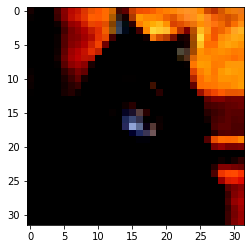

In [22]:
img, label = data_set[5]
plt.imshow(img.permute(1,2,0))
class_names[label]

In [23]:
out = model(img.view(-1).unsqueeze(0))
out

tensor([[0.3838, 0.6162]], grad_fn=<SoftmaxBackward>)

In [24]:
_, index = torch.max(out, dim=1)
print('->',class_names[label],' model:',class_names[index])

-> cat  model: cat


In [25]:
softmax = nn.Softmax(dim=1)
log_softmax = nn.LogSoftmax(dim=1)
x = torch.tensor([[0.0, 110.0]])
softmax(x)

tensor([[0., 1.]])

In [26]:
print(torch.log(softmax(x)))
print(log_softmax(x))
print(torch.exp(log_softmax(x)))

tensor([[-inf, 0.]])
tensor([[-110.,    0.]])
tensor([[0., 1.]])


### Use the model

https://h1ros.github.io/posts/3-ways-of-creating-a-neural-network-in-pytorch/

There are three ways to create a neural network in PyTorch:

nn.Module
nn.Sequential
nn.ModuleList

In [27]:
model = nn.Sequential(nn.Linear(3072,512),nn.Tanh(),nn.Linear(512,2),nn.LogSoftmax(dim=1))
loss = nn.NLLLoss()

"""Applies a linear transformation to the incoming data: y = x*W^T + b.
Parameters: in_features – size of each input sample (i.e. size of x)F"""

'Applies a linear transformation to the incoming data: y = x*W^T + b.\nParameters: in_features – size of each input sample (i.e. size of x)F'

In [28]:
img, label = data_set[20]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
print('->',class_names[label],' model:',class_names[index])
loss(out, torch.tensor([label]))

-> dog  model: cat


tensor(0.7744, grad_fn=<NllLossBackward>)

In [29]:
model = nn.Sequential(nn.Linear(3072,512),nn.Tanh(),nn.Linear(512,2),nn.LogSoftmax(dim=1))

In [30]:
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
lossFunction = nn.NLLLoss()
n_epochs = 5
for epoch in range(n_epochs):
    for img, label in data_set:
        out = model(img.view(-1).unsqueeze(0))
        loss = lossFunction(out, torch.tensor([label]))           
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 27.862730
Epoch: 1, Loss: 8.917773
Epoch: 2, Loss: 0.000000
Epoch: 3, Loss: 0.000000
Epoch: 4, Loss: 15.217024


In [31]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)
model = nn.Sequential(nn.Linear(3072,512),nn.Tanh(),nn.Linear(512,2),nn.LogSoftmax(dim=1))
optimizer = optim.SGD(model.parameters(), lr=0.02)
loss_function = nn.NLLLoss()
n_epochs = 30
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.402248
Epoch: 1, Loss: 0.586870
Epoch: 2, Loss: 0.501436
Epoch: 3, Loss: 0.621213
Epoch: 4, Loss: 0.311389
Epoch: 5, Loss: 0.400948
Epoch: 6, Loss: 0.286767
Epoch: 7, Loss: 0.474512
Epoch: 8, Loss: 0.358126
Epoch: 9, Loss: 0.699109
Epoch: 10, Loss: 0.247424
Epoch: 11, Loss: 0.283251
Epoch: 12, Loss: 0.184839
Epoch: 13, Loss: 0.215712
Epoch: 14, Loss: 0.152946
Epoch: 15, Loss: 0.117366
Epoch: 16, Loss: 0.090995
Epoch: 17, Loss: 0.038935
Epoch: 18, Loss: 0.078705
Epoch: 19, Loss: 0.057111
Epoch: 20, Loss: 0.036518
Epoch: 21, Loss: 0.022566
Epoch: 22, Loss: 0.123533
Epoch: 23, Loss: 0.032600
Epoch: 24, Loss: 0.032964
Epoch: 25, Loss: 0.104996
Epoch: 26, Loss: 0.058973
Epoch: 27, Loss: 0.028902
Epoch: 28, Loss: 0.013937
Epoch: 29, Loss: 0.020078


In [32]:
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())    
print("Accuracy: %f" % (correct / total))

Accuracy: 0.873500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->:  cat  model: cat


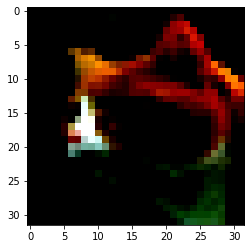

In [33]:
img, label = validation_set[15]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
print('->: ',class_names[label],' model:',class_names[index])
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [34]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)
model=nn.Sequential(nn.Linear(3072,1024),nn.Tanh(),nn.Linear(1024,512),nn.Tanh(),nn.Linear(512,128),nn.Tanh(),nn.Linear(128,2))
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 30
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.416611
Epoch: 1, Loss: 0.430878
Epoch: 2, Loss: 0.284029
Epoch: 3, Loss: 0.479533
Epoch: 4, Loss: 0.285296
Epoch: 5, Loss: 0.561367
Epoch: 6, Loss: 0.299657
Epoch: 7, Loss: 0.388630
Epoch: 8, Loss: 0.180105
Epoch: 9, Loss: 0.380780
Epoch: 10, Loss: 0.324003
Epoch: 11, Loss: 0.374358
Epoch: 12, Loss: 0.099142
Epoch: 13, Loss: 0.312310
Epoch: 14, Loss: 0.178625
Epoch: 15, Loss: 0.205934
Epoch: 16, Loss: 0.403093
Epoch: 17, Loss: 0.330182
Epoch: 18, Loss: 0.245195
Epoch: 19, Loss: 0.172184
Epoch: 20, Loss: 0.157341
Epoch: 21, Loss: 0.199930
Epoch: 22, Loss: 0.154313
Epoch: 23, Loss: 0.292258
Epoch: 24, Loss: 0.209760
Epoch: 25, Loss: 0.245658
Epoch: 26, Loss: 0.140228
Epoch: 27, Loss: 0.023821
Epoch: 28, Loss: 0.019153
Epoch: 29, Loss: 0.014387


In [35]:
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())       
print("Accuracy: %f" % (correct / total))

Accuracy: 0.847000


In [36]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())       
print("Accuracy: %f" % (correct / total))

Accuracy: 0.985200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct:  cat  model: dog


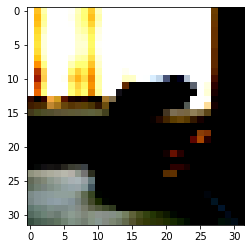

In [37]:
img, label = validation_set[8]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
print('correct: ',class_names[label],' model:',class_names[index])
plt.imshow(img.permute(1, 2, 0))

In [38]:
print(sum([p.numel() for p in model.parameters() if p.requires_grad == True]))
print(sum([p.numel() for p in nn.Linear(3072, 512).parameters()]))
print(sum([p.numel() for p in nn.Linear(3072, 1024).parameters()]))

3737474
1573376
3146752


In [43]:
cat = request.urlretrieve('https://estaticos.elperiodico.com/resources/jpg/1/6/gato-1502194230861.jpg','WonderCat.jpg')
img = Image.open(cat[0])

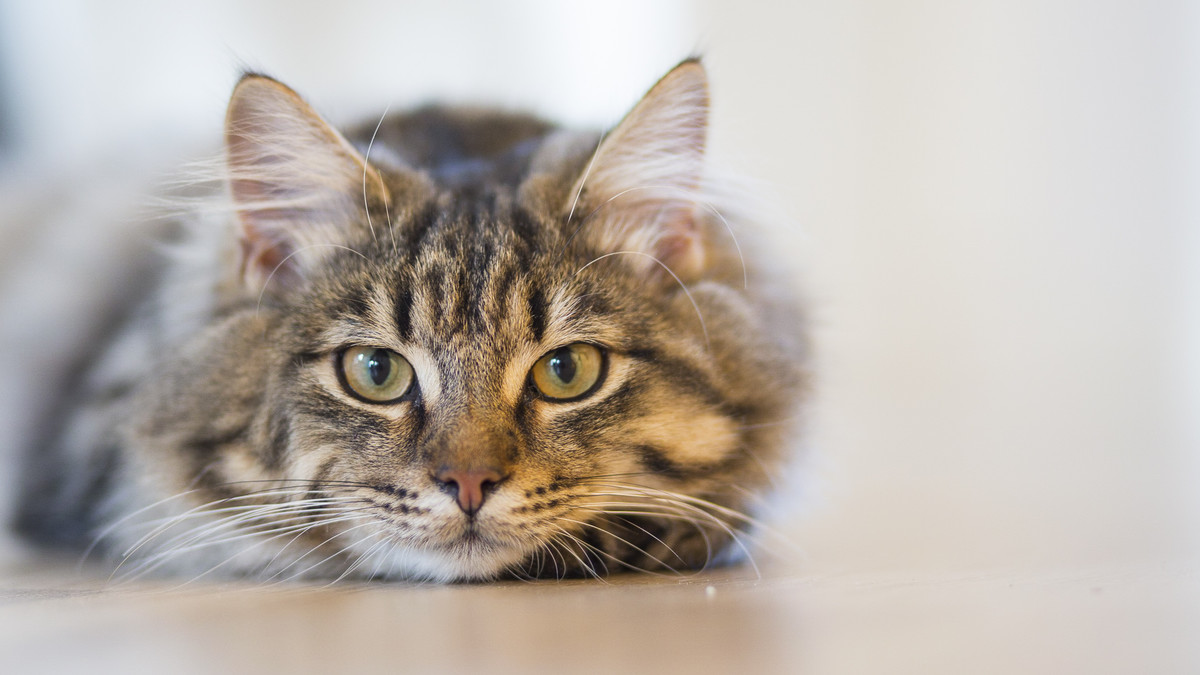

In [44]:
img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct: cat   model: cat


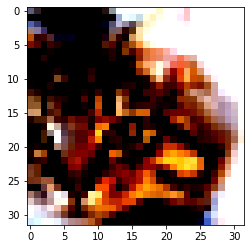

In [54]:
preprocess = transforms.Compose([transforms.Resize(48),transforms.CenterCrop(32),transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4915, 0.4823, 0.4468],
            std=[0.2470, 0.2435, 0.2616])])
img_t = preprocess(img)
out = model(img_t.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
print('correct: cat ',' model:',class_names[index])
plt.imshow(img_t.permute(1, 2, 0))

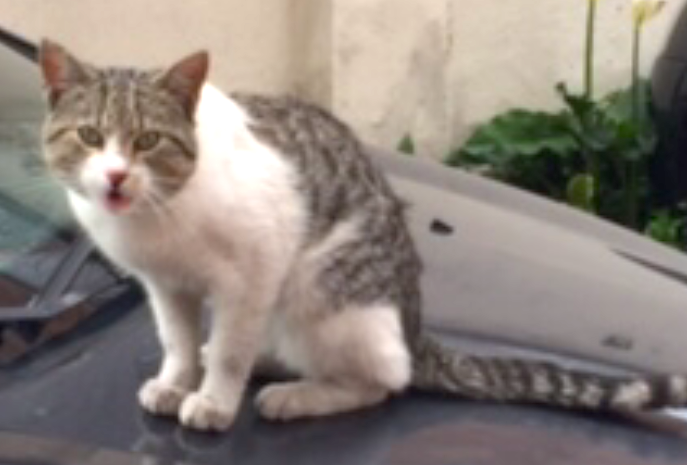

In [64]:
cat1 = Image.open('WonderCat-ForAdoption.png').convert('RGB')
cat1
# Without 'convert('RGB')', it has 4 channels instead of 3. For further details see:
# https://stackoverflow.com/questions/58496858/pytorch-runtimeerror-the-size-of-tensor-a-4-must-match-the-size-of-tensor-b

In [ ]:
# pix = np.array(cat1) #Converts pil image into numpy array
# img1 = torch.from_numpy(pix)
# image = ToTensor()(pix).unsqueeze(0) # Converts to Tensor
# img1 = Image.open(cat1[0])

# In the end 'img_t = preprocess(cat1)' receives a pil image and not a tensor, so this is not needed.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct: cat   model: cat


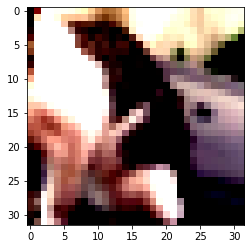

In [66]:
preprocess = transforms.Compose([transforms.Resize(48),transforms.CenterCrop(32),transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4915, 0.4823, 0.4468],
            std=[0.2470, 0.2435, 0.2616])])
img_t = preprocess(cat1)  # Requieres an image with three (3) channels.
out = model(img_t.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
print('correct: cat ',' model:',class_names[index])
plt.imshow(img_t.permute(1, 2, 0))